# Playing around with some of the methods that Martin uses in his Medium Article ["Creating Algorithmic Art with Python"](https://medium.com/better-programming/creating-algorithmic-art-with-python-edb5c5ea0a87)

In [59]:
pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 kB 896.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pillow

### Start as basic as we can get.  Start with a line, and lets tinker a bit with PIL methods:

In [18]:
from PIL import Image, ImageDraw  # pip install pillow for PIL

# Define the canvas size
width = 800
height = 600
im = Image.new("RGB", (width, height), (255, 0, 255))
draw = ImageDraw.Draw(im)

# Draw a single line and make it pretty diagonal, so we can see how the pixels try to form a straight line by default.  
# You'll see how bad the distortion is at this resolution.
x1, y1 = 100, 50
x2, y2 = 1000, 500
color = (255, 590, 0)  # rgb, you can exceed max values??  That's funny.  So it just assumes the max 255 when an input value exceed that.  
draw.line((x1, y1, x2, y2), fill=color)

# Save the image as a PNG
im.save("yellow on magenta (an original piece).png", "PNG")

#### There are only 16,581,375 (255^3) possible colors that can be created in the RGB scale.<br />I hope that is enough for us  :p

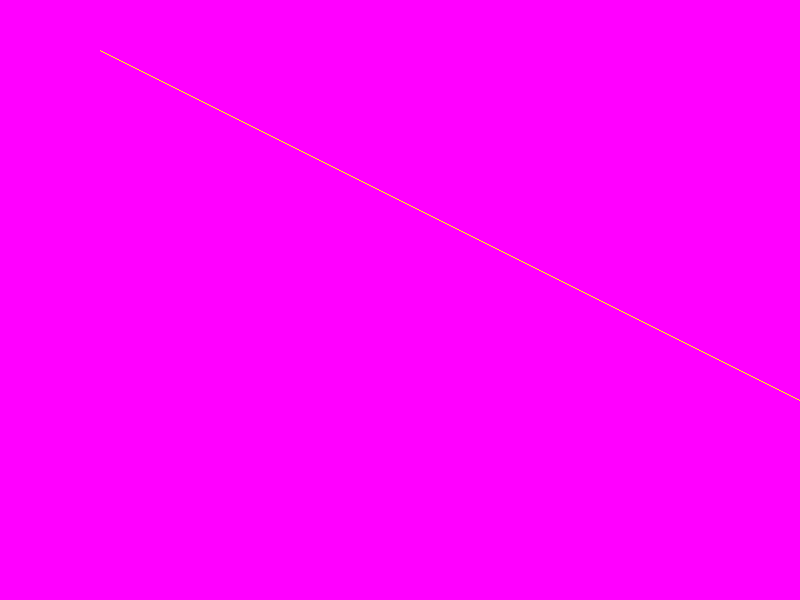

In [60]:
Image.open("yellow on magenta (an original piece).png")

#### If your eyes aren't burned out of your sockets from that beauty, let's move on, shall we?<br />
### Time to learn about the signal processing technique that changed computer graphics forever! <br />  https://en.wikipedia.org/wiki/Spatial_anti-aliasing

In [22]:
"""Library to draw an antialiased line. Thank you Xiaolin Wu and Toastie of StackOverflow"""
# http://stackoverflow.com/questions/3122049/drawing-an-anti-aliased-line-with-thepython-imaging-library
# https://en.wikipedia.org/wiki/Xiaolin_Wu%27s_line_algorithm
import math


def plot(draw, img, x, y, c, col, steep, dash_interval):
    """Draws an antiliased pixel on a line."""
    if steep:
        x, y = y, x
    if x < img.size[0] and y < img.size[1] and x >= 0 and y >= 0:
        c = c * (float(col[3]) / 255.0)
        p = img.getpixel((x, y))
        x = int(x)
        y = int(y)
        if dash_interval:
            d = dash_interval - 1
            if (x / dash_interval) % d == 0 and (y / dash_interval) % d == 0:
                return
        draw.point((x, y), fill=(
            int((p[0] * (1 - c)) + col[0] * c),
            int((p[1] * (1 - c)) + col[1] * c),
            int((p[2] * (1 - c)) + col[2] * c), 255))


def iround(x):
    """Rounds x to the nearest integer."""
    return ipart(x + 0.5)


def ipart(x):
    """Floors x."""
    return math.floor(x)


def fpart(x):
    """Returns the fractional part of x."""
    return x - math.floor(x)


def rfpart(x):
    """Returns the 1 minus the fractional part of x."""
    return 1 - fpart(x)


def draw_line_antialiased(draw, img, x1, y1, x2, y2, col, dash_interval=None):
    """Draw an antialised line in the PIL ImageDraw.

    Implements the Xialon Wu antialiasing algorithm.

    col - color
    """
    dx = x2 - x1
    if not dx:
        draw.line((x1, y1, x2, y2), fill=col, width=1)
        return

    dy = y2 - y1
    steep = abs(dx) < abs(dy)
    if steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
        dx, dy = dy, dx
    if x2 < x1:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
    gradient = float(dy) / float(dx)

    # handle first endpoint
    xend = round(x1)
    yend = y1 + gradient * (xend - x1)
    xgap = rfpart(x1 + 0.5)
    xpxl1 = xend    # this will be used in the main loop
    ypxl1 = ipart(yend)
    plot(draw, img, xpxl1, ypxl1, rfpart(yend) * xgap, col, steep,
         dash_interval)
    plot(draw, img, xpxl1, ypxl1 + 1, fpart(yend) * xgap, col, steep,
         dash_interval)
    intery = yend + gradient  # first y-intersection for the main loop

    # handle second endpoint
    xend = round(x2)
    yend = y2 + gradient * (xend - x2)
    xgap = fpart(x2 + 0.5)
    xpxl2 = xend    # this will be used in the main loop
    ypxl2 = ipart(yend)
    plot(draw, img, xpxl2, ypxl2, rfpart(yend) * xgap, col, steep,
         dash_interval)
    plot(draw, img, xpxl2, ypxl2 + 1, fpart(yend) * xgap, col, steep,
         dash_interval)

    # main loop
    for x in range(int(xpxl1 + 1), int(xpxl2)):
        plot(draw, img, x, ipart(intery), rfpart(intery), col, steep,
             dash_interval)
        plot(draw, img, x, ipart(intery) + 1, fpart(intery), col, steep,
             dash_interval)
        intery = intery + gradient

### Now for Martin's implementation of drawing multiple rectangles on the same image:

In [137]:
from dataclasses import dataclass
from typing import List, Tuple

# Just store https://stackoverflow.com/a/5709655/562769
# as anti_aliased_line.py in the same directory
from PIL import Image, ImageDraw


@dataclass
class Point:
    x: float
    y: float


@dataclass
class Line:
    p1: Point
    p2: Point

    def position(self, p: float) -> Point:
        return Point(
            self.p1.x + (self.p2.x - self.p1.x) * p,
            self.p1.y + (self.p2.y - self.p1.y) * p,
        )


@dataclass
class Rectangle:
    p1: Point
    p2: Point
    p3: Point
    p4: Point

    def __getitem__(self, key: int) -> Point:
        if key == 0:
            return self.p1
        elif key == 1:
            return self.p2
        elif key == 2:
            return self.p3
        elif key == 3:
            return self.p4
        raise ValueError(f"key = {key} is invalid")

    def __setitem__(self, key: int, value: Point) -> None:
        if key == 0:
            self.p1 = value
        elif key == 1:
            self.p2 = value
        elif key == 2:
            self.p3 = value
        elif key == 3:
            self.p4 = value
        else:
            raise ValueError(f"key = {key} is invalid")


def new_point(rect: Rectangle, i: int, pct: float = .1) -> Point:
    if i == 0:
        return Line(rect.p1, rect.p2).position(pct)
    elif i == 1:  # top
        return Line(rect.p2, rect.p3).position(pct)
    elif i == 2:
        return Line(rect.p3, rect.p4).position(pct)
    elif i == 3:
        return Line(rect.p4, rect.p1).position(pct)
    raise ValueError(f"i = {i} is invalid")


def get_color(i: int) -> Tuple[int, int, int, int]:
    r = i *100% 256
    g = i %256
    b =  i % 256
    return (r, g, b, 255)


def main():
    width = 500
    height = 500
    im = Image.new("RGB", (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(im)
    rectangle = Rectangle(
        Point(0, 0), Point(width, 0), Point(width, height), Point(0, height)
    )

    for i in range(1000):
        p1 = rectangle[i % 4]
        p2 = rectangle[(i + 1) % 4]
        draw_line_antialiased(draw, im, p1.x, p1.y, p2.x, p2.y, get_color(i))
        # draw.line((p1.x, p1.y, p2.x, p2.y), fill=get_color(i))
        rectangle[i % 4] = new_point(rectangle, i % 4, pct=.0025)

    # write to stdout
    im.save("rectangles.png", "PNG")


if __name__ == "__main__":
    main()

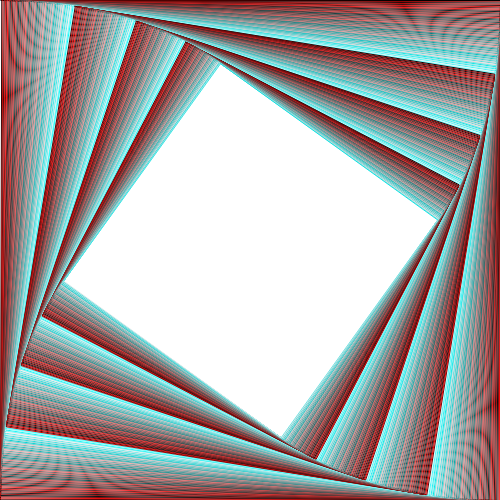

In [138]:
Image.open("rectangles.png")

### Now imagine doing this over a range of different percentages (Still don't fully understand how these work in the algo, will come back to explain this better).  Let's take our main function from above, make it a function, and call it over a range of percentages.

In [78]:
def create_frame(percentage: float, output_file: str=None) -> Image:
    """
    Args:
      output_file: str - Filename to save newly generated frame to.  Will be a png, so filename should incude .png ext
      percentage: float - A percentage expressed in decimal form (Between 0 and 1).  Still not sure how this works exactly.

    Output:
        None: Frame saved to input filename
    """
    width = 350
    height = 350
    im = Image.new("RGB", (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(im)
    rectangle = Rectangle(
        Point(0, 0), Point(width, 0), Point(width, height), Point(0, height)
    )

    for i in range(1000):
        p1 = rectangle[i % 4]
        p2 = rectangle[(i + 1) % 4]
        draw_line_antialiased(draw, im, p1.x, p1.y, p2.x, p2.y, get_color(i))
        # draw.line((p1.x, p1.y, p2.x, p2.y), fill=get_color(i))
        rectangle[i % 4] = new_point(rectangle, i % 4, pct=percentage)

    # write to stdout
    if output_file:
        im.save(output_file, "PNG")

    return im

### For the gif creation, we need to use the above function to make many frames.  The following will create 100+ images under test_range/

In [ ]:
frames = []
#print(np.arange(.001, .015, .00005))

# Creating Frames from scratch:
for i, p in enumerate(np.arange(.001, .015, .0001)):
    frames.append(create_frame(p, f"test_range/rectangles_{str(i).zfill(3)}.png"))

# Using Frames already created:
# for i, p in enumerate(np.arange(.001, .004, .00005)):
#     frames.append(Image.open(f"test_range/rectangles_{round(i,4)}.png"))


### Considering all the image I am making, and with varying parameters, we need some general conventions  for gif naming: (Not really set on including RGB values in the filename, my cli example doesn't have them included as you'll see.)

`<Shape>_<Percent(%) Range>_<Step Size>_<Pixel Size (1 value implies the gif is square)>_RGB-<Red-Green-Blue Values>.gif`

i.e.  rectagles_001-015_00005_350_RGB-255-255-255.gif

### Now for the gif creation, using magick cli:

```bash
chasececora@Chases-MacBook-Air ~ $ magick convert -delay 5 -loop 0 -dispose None  *png   magick_001-015_00005_step_350.gif
```

### Now for the final result....

In [154]:
from IPython.display import display, HTML
display(HTML('<center><img src="will_smith_meme.jpeg" width="250" align="center"><img src="test_range/magick_001-015_0001_step_350.gif" width="350" align="center"></center>'))